# Project: Analysis of Bank Stocks from US, Japan, and Hong Kong

## Introduction: 

* Background: 

* Aim: 


In [1]:
# Requirements 
!pip install yfinance 

In [37]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.common.exceptions import NoSuchElementException
import pandas as pd
import time

driver_path = "/usr/local/bin/chromedriver"

# Chrome Driver setup 
service = Service(driver_path)
options = Options()
options.add_argument("--start-maximized")
options.add_argument("user-agent=Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 Chrome/120 Safari/537.36")

driver = webdriver.Chrome(service=service, options=options)

# Japan 
url_jp = "https://www.google.com/search?q=Japan+interest+rate&sca_esv=cab469c6dae8b008&tbs=cdr:1,cd_min:1/1/2025,sbd:1&tbm=nws"

driver.get(url_jp)
time.sleep(10)

In [38]:
jp_news_data = []

while True:
    # Find the news items (using CSS selectors, adjust as needed)
    news_items = driver.find_elements(By.CSS_SELECTOR, "div.SoaBEf") #div.SoaBEf
    # Extract data from each item
    for item in news_items:
        try:
            # Extract headline
            headline = item.find_element(By.CSS_SELECTOR, "div.n0jPhd.ynAwRc.MBeuO.nDgy9d").text #n0jPhd ynAwRc MBeuO nDgy9d

            # Extract source (adjust selector if needed)
            source = item.find_element(By.CSS_SELECTOR, "div.MgUUmf.NUnG9d").text

            # Extract snippet (adjust selector if needed)
            intro = item.find_element(By.CSS_SELECTOR, "div.GI74Re.nDgy9d").text

            # Extract date 
            date = item.find_element(By.CSS_SELECTOR, "div.OSrXXb.rbYSKb.LfVVr").text #OSrXXb rbYSKb LfVVr

            jp_news_data.append({
                "headline": headline,
                "source": source,
                "intro": intro,
                "date": date
            })
        except Exception as e:
            print(f"Error extracting data: {e}")
    try:
        next_button = driver.find_element(By.ID, "pnnext") 
        # next_button = driver.find_element(By.CSS_SELECTOR, "td.d6cvqb.BBwThe a")
        next_button.click()
        time.sleep(5)
    except Exception as e:
        print(f"Error: {e}")
        break
    
# 5. Converting the results into a DataFrame 
jp_news_df = pd.DataFrame(jp_news_data)

# 6. Saving into .csv
jp_news_df.to_csv("jp_news.csv", index=False)

# Close the browser
driver.quit()

Error: Message: no such element: Unable to locate element: {"method":"css selector","selector":"[id="pnnext"]"}
  (Session info: chrome=138.0.7204.158); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
0   chromedriver                        0x0000000109232728 chromedriver + 5891880
1   chromedriver                        0x0000000109229e7a chromedriver + 5856890
2   chromedriver                        0x0000000108cfa400 chromedriver + 418816
3   chromedriver                        0x0000000108d4c22b chromedriver + 754219
4   chromedriver                        0x0000000108d4c441 chromedriver + 754753
5   chromedriver                        0x0000000108d9ccd4 chromedriver + 1084628
6   chromedriver                        0x0000000108d7250d chromedriver + 910605
7   chromedriver                        0x0000000108d9a073 chromedriver + 1073267
8   chromedriver                      

In [39]:
jp_news_df.head()

,headline,source,intro,date
0,What Signals Did the Bank of Japan's Release o...,Binance,The recent quietly initiated dollar liquidity ...,1 day ago
1,Bank of Japan may offer less gloomy view of US...,Reuters,The Bank of Japan will warn of uncertainty ove...,3 days ago
2,"Week Ahead: Japan Election, ECB Interest Rate ...",Markets.com,The week begins with Japan's Upper House elect...,5 days ago
3,Interest rates on Japanese and U.S. government...,매일경제,Interest rates on Japanese and U.S. government...,6 days ago
4,Japan election could further hamper BOJ's driv...,Reuters,Japan's central bank may face political pressu...,1 week ago


In [40]:
len(jp_news_df)

280

In [42]:
jp_news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280 entries, 0 to 279
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   headline  280 non-null    object
 1   source    280 non-null    object
 2   intro     280 non-null    object
 3   date      280 non-null    object
dtypes: object(4)
memory usage: 8.9+ KB


In [ ]:
from datetime import datetime, timedelta
import pandas as pd
import re

# Current time 
now = datetime.now() 

def parse_relative_time(date_string): 
    date_string = date_string.lower().strip()
    if date_string == 'just now': 
        return now 
    match = re.match(r'(\d+)\s+(day|week|month|year)s?\s+ago', date_string)
    if match: 
        value, unit = int(match.group(1)), match.group(2)
        # simply assume 1 month = 30 days, 1 year = 365 days
        multiplier = {
            'second': timedelta(seconds=value),
            'minute': timedelta(minutes=value),
            'hour': timedelta(hours=value),
            'day': timedelta(days=value),
            'week': timedelta(weeks=value),
            'month': timedelta(days=30*value),
            'year': timedelta(days=365*value)
        }
        return now - multiplier[unit]
    return pd.NaT # for inconvertable scenarios 

jp_news_df['datetime'] = jp_news_df['date'].apply(parse_relative_time).dt.date
jp_news_df

,headline,source,intro,date,datetime
0,What Signals Did the Bank of Japan's Release o...,Binance,The recent quietly initiated dollar liquidity ...,1 day ago,2025-07-20
1,Bank of Japan may offer less gloomy view of US...,Reuters,The Bank of Japan will warn of uncertainty ove...,3 days ago,2025-07-18
2,"Week Ahead: Japan Election, ECB Interest Rate ...",Markets.com,The week begins with Japan's Upper House elect...,5 days ago,2025-07-16
3,Interest rates on Japanese and U.S. government...,매일경제,Interest rates on Japanese and U.S. government...,6 days ago,2025-07-15
4,Japan election could further hamper BOJ's driv...,Reuters,Japan's central bank may face political pressu...,1 week ago,2025-07-14
...,...,...,...,...,...
275,BOJ official says wage hike signs positive fac...,朝日新聞,A Bank of Japan deputy governor hinted that th...,15 Jan 2025,NaT
276,How yen carry trades impact the markets,Finshots,"In today's Finshots, we look at how Japan's ra...",7 Jan 2025,NaT
277,Japan’s Fiscal 2025 Budget Reaches Record High...,nippon.com,Social security spending and servicing the nat...,7 Jan 2025,NaT
278,Record-Breaking Monthly and Yearly Volume in C...,日本取引所グループ,"Japan Securities Clearing Corporation (""JSCC"")...",6 Jan 2025,NaT


For dates that are formatted in # days/months/years ago -> it's now showing in the '%Y-%m-%d' format

However, the dates in the format of '%d %b %Y' still need to be converted 

In [53]:
#temporarily saving the NaT rows into a new dataframe 
tmp_df = jp_news_df.loc[jp_news_df['datetime'].isna()]

In [54]:
tmp_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 205 entries, 75 to 279
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   headline  205 non-null    object
 1   source    205 non-null    object
 2   intro     205 non-null    object
 3   date      205 non-null    object
 4   datetime  0 non-null      object
dtypes: object(5)
memory usage: 9.6+ KB


In [ ]:
# convert the date's dtype to datetime
tmp_df['date_parsed'] = pd.to_datetime(tmp_df['date'], format='%d %b %Y') 
tmp_df.info() 

<class 'pandas.core.frame.DataFrame'>
Index: 205 entries, 75 to 279
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   headline     205 non-null    object        
 1   source       205 non-null    object        
 2   intro        205 non-null    object        
 3   date         205 non-null    object        
 4   datetime     0 non-null      object        
 5   date_parsed  205 non-null    datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 11.2+ KB


/var/folders/n3/kjpx2ctx5mb_d1p6ntdrl7hr0000gn/T/ipykernel_6704/1741756404.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['date_parsed'] = pd.to_datetime(tmp_df['date'], format='%d %b %Y')


newly created column 'date_parsed' is no longer 'object', it's 'datetime' Dtype

In [62]:
# convert to '%Y-%m-%d' in the 'datetime' column
tmp_df['datetime'] = tmp_df['date_parsed'].dt.strftime('%Y-%m-%d')
tmp_df.head()

/var/folders/n3/kjpx2ctx5mb_d1p6ntdrl7hr0000gn/T/ipykernel_6704/3115136998.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['datetime'] = tmp_df['date_parsed'].dt.strftime('%Y-%m-%d')


,headline,source,intro,date,datetime,date_parsed
75,Week Ahead: Australia CPI and RBNZ Interest Ra...,Markets.com,"On Wednesday, 28 May, Australia's CPI (01:30 G...",24 May 2025,2025-05-24,2025-05-24
76,"Japan’s core inflation heats up, increasing Ju...",ING Think,Japan's headline consumer price index (CPI) re...,23 May 2025,2025-05-23,2025-05-23
77,Bank of Japan policymaker rules out interventi...,The Business Times,The central bank must pause its rate hikes for...,22 May 2025,2025-05-22,2025-05-22
78,Japan and U.S. reaffirm commitment to letting ...,The Japan Times,Finance Minister Katsunobu Kato and U.S. Treas...,22 May 2025,2025-05-22,2025-05-22
79,"Bank of Japan’s Rate-Hike Window Narrowing, Ex...",MSN,If the Bank of Japan wants to raise interest r...,21 May 2025,2025-05-21,2025-05-21


In [64]:
# replace NaT cells in the original dataframe 
jp_news_df.loc[jp_news_df['datetime'].isna(), 'datetime'] = tmp_df['datetime']
jp_news_df

,headline,source,intro,date,datetime
0,What Signals Did the Bank of Japan's Release o...,Binance,The recent quietly initiated dollar liquidity ...,1 day ago,2025-07-20
1,Bank of Japan may offer less gloomy view of US...,Reuters,The Bank of Japan will warn of uncertainty ove...,3 days ago,2025-07-18
2,"Week Ahead: Japan Election, ECB Interest Rate ...",Markets.com,The week begins with Japan's Upper House elect...,5 days ago,2025-07-16
3,Interest rates on Japanese and U.S. government...,매일경제,Interest rates on Japanese and U.S. government...,6 days ago,2025-07-15
4,Japan election could further hamper BOJ's driv...,Reuters,Japan's central bank may face political pressu...,1 week ago,2025-07-14
...,...,...,...,...,...
275,BOJ official says wage hike signs positive fac...,朝日新聞,A Bank of Japan deputy governor hinted that th...,15 Jan 2025,2025-01-15
276,How yen carry trades impact the markets,Finshots,"In today's Finshots, we look at how Japan's ra...",7 Jan 2025,2025-01-07
277,Japan’s Fiscal 2025 Budget Reaches Record High...,nippon.com,Social security spending and servicing the nat...,7 Jan 2025,2025-01-07
278,Record-Breaking Monthly and Yearly Volume in C...,日本取引所グループ,"Japan Securities Clearing Corporation (""JSCC"")...",6 Jan 2025,2025-01-06


As the tmp_df's the NaT rows got the same indices from the original jp_news_df, I was able to replace the NaT rows with the above command

We want to group the news articles by the 'month' published so let's strip the date into '%Y-%m' format

In [ ]:
# convert datetime's Dtype 
jp_news_df['datetime'] = pd.to_datetime(jp_news_df['datetime'], format='%Y-%m-%d')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280 entries, 0 to 279
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   headline  280 non-null    object        
 1   source    280 non-null    object        
 2   intro     280 non-null    object        
 3   date      280 non-null    object        
 4   datetime  280 non-null    datetime64[ns]
dtypes: datetime64[ns](1), object(4)
memory usage: 11.1+ KB


In [68]:
# Create a new column called 'month' that shows each article's published month in '%Y-%m' format
jp_news_df['month'] = jp_news_df['datetime'].dt.strftime('%Y-%m')
jp_news_df.head()

,headline,source,intro,date,datetime,month
0,What Signals Did the Bank of Japan's Release o...,Binance,The recent quietly initiated dollar liquidity ...,1 day ago,2025-07-20,2025-07
1,Bank of Japan may offer less gloomy view of US...,Reuters,The Bank of Japan will warn of uncertainty ove...,3 days ago,2025-07-18,2025-07
2,"Week Ahead: Japan Election, ECB Interest Rate ...",Markets.com,The week begins with Japan's Upper House elect...,5 days ago,2025-07-16,2025-07
3,Interest rates on Japanese and U.S. government...,매일경제,Interest rates on Japanese and U.S. government...,6 days ago,2025-07-15,2025-07
4,Japan election could further hamper BOJ's driv...,Reuters,Japan's central bank may face political pressu...,1 week ago,2025-07-14,2025-07


### Merging headlines and intros -> 1 string per month

In [69]:
# create a new column to concatenate headlines and introductions into one string 
jp_news_df['full_content'] = jp_news_df['headline']+" "+jp_news_df['intro']+" "
jp_news_df.head()

,headline,source,intro,date,datetime,month,full_content
0,What Signals Did the Bank of Japan's Release o...,Binance,The recent quietly initiated dollar liquidity ...,1 day ago,2025-07-20,2025-07,What Signals Did the Bank of Japan's Release o...
1,Bank of Japan may offer less gloomy view of US...,Reuters,The Bank of Japan will warn of uncertainty ove...,3 days ago,2025-07-18,2025-07,Bank of Japan may offer less gloomy view of US...
2,"Week Ahead: Japan Election, ECB Interest Rate ...",Markets.com,The week begins with Japan's Upper House elect...,5 days ago,2025-07-16,2025-07,"Week Ahead: Japan Election, ECB Interest Rate ..."
3,Interest rates on Japanese and U.S. government...,매일경제,Interest rates on Japanese and U.S. government...,6 days ago,2025-07-15,2025-07,Interest rates on Japanese and U.S. government...
4,Japan election could further hamper BOJ's driv...,Reuters,Japan's central bank may face political pressu...,1 week ago,2025-07-14,2025-07,Japan election could further hamper BOJ's driv...


In [70]:
# group all 'full_content' by months 
monthly_content = jp_news_df.groupby('month')['full_content'].sum()
monthly_content

month
2025-01    Bank of Japan could face capital losses if int...
2025-02    Odds of early rate rise increase as inflation ...
2025-03    Japan core inflation rose 3% in February, bols...
2025-04    Bank of Japan slashes growth forecasts on tari...
2025-05    Week Ahead: Australia CPI and RBNZ Interest Ra...
2025-06    Inflation rate and interest rate by country 20...
2025-07    What Signals Did the Bank of Japan's Release o...
Name: full_content, dtype: object

In [16]:
import yfinance as yf 

jp_tickers = ["8306.T", "8316.T", "5830.T", "8399.T", "5831.T"]
                #Mitsubishi UFJ 8306.T
                #Sumitomo 8316.T
                #Iyogin Holdings 5830.T
                #Bank of The Ryukyus 8399.T
                #Shizuoka Bank 5831.T

jp_stocks_df = yf.download(jp_tickers, period="6mo", interval="1d")["Close"]

print(jp_stocks_df.head())

/var/folders/n3/kjpx2ctx5mb_d1p6ntdrl7hr0000gn/T/ipykernel_6704/1834508423.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  jp_stocks_df = yf.download(jp_tickers, period="6mo", interval="1d")["Close"]
[*********************100%***********************]  5 of 5 completed

Ticker           5830.T  5831.T  8306.T       8316.T       8399.T
Date                                                             
2025-01-20  1589.081665  1353.5  1915.5  3772.612061  1077.862427
2025-01-21  1575.272095  1329.5  1918.0  3747.008301  1093.612061
2025-01-22  1575.272095  1341.0  1906.5  3718.450439  1088.690308
2025-01-23  1567.380981  1332.0  1907.0  3714.511230  1066.050293
2025-01-24  1583.163330  1333.5  1907.0  3692.846680  1056.206787


In [17]:
jp_stocks_df.head()

Ticker,5830.T,5831.T,8306.T,8316.T,8399.T
Date,,,,,
2025-01-20,1589.081665,1353.5,1915.5,3772.612061,1077.862427
2025-01-21,1575.272095,1329.5,1918.0,3747.008301,1093.612061
2025-01-22,1575.272095,1341.0,1906.5,3718.450439,1088.690308
2025-01-23,1567.380981,1332.0,1907.0,3714.511230,1066.050293
2025-01-24,1583.163330,1333.5,1907.0,3692.846680,1056.206787


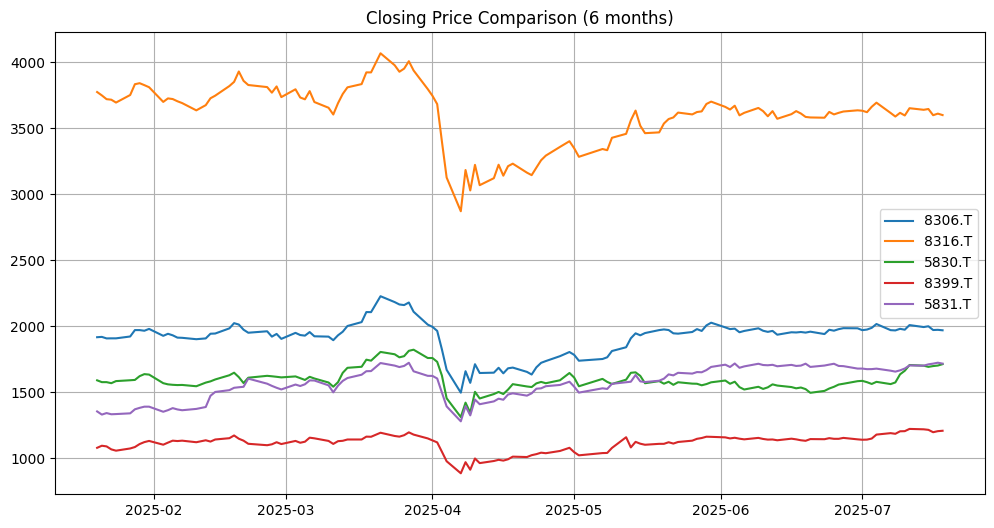

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for symbol in jp_tickers:
    plt.plot(jp_stocks_df[symbol], label=symbol)
plt.title("Closing Price Comparison (6 months)")
plt.legend()
plt.grid(True)
plt.show()

In [19]:
for symbol in jp_tickers:
    t = yf.Ticker(symbol)
    info = t.info
    price = info.get("currentPrice")
    eps = info.get("trailingEps")
    bps = info.get("bookValue")
    roe = info.get("returnOnEquity")

    per = price / eps if eps else None
    pbr = price / bps if bps else None

    print(f"[{symbol}]")
    print(f"PER: {per:.2f}")
    print(f"PBR: {pbr:.2f}")
    print(f"ROE: {roe:.2%}")
    print("-----------")

[8306.T]
PER: 12.35
PBR: 1.24
ROE: 9.66%
-----------
[8316.T]
PER: 11.93
PBR: 0.96
ROE: 3.15%
-----------
[5830.T]
PER: 9.62
PBR: 0.63
ROE: 6.48%
-----------
[8399.T]
PER: 8.69
PBR: 0.36
ROE: 4.07%
-----------
[5831.T]
PER: 12.58
PBR: 0.80
ROE: 6.30%
-----------


In [ ]:
# US

# Hong Kong 